# Funghi Classification v3


Usefull imports, try to keep all of them here and labeled!

In [1]:
''' Linear Algebra'''
import pandas as pd
import numpy as np

''' Data visualization'''
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix

''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization

'''Image loading I believe'''
from tqdm import tqdm
from PIL import Image
import itertools

Choices for run time:


In [2]:
#if you want to train on 1k images choose '_r36.jpg' otherwise '.jpg'
quantity_train='.jpg'

Don't forget to enable GPU acceleration!

`Runtime` $\rightarrow$ `Change runtime type` $\rightarrow$ `Hardware accelerator` $\rightarrow$ `GPU`

Mount your google drive!

In [3]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive')
# Put Colab in the context of this challenge
import os
# os.chdir allows you to change directories, like cd in the Terminal
my_drive_path="/Colab Notebooks/data-transfer-learning"  #Change accordingly to the path of your project folder
os.chdir('/content/drive/MyDrive'+my_drive_path) 

Mounted at /content/drive


## (1) Dataset Loading

In [4]:
!pwd #Check path of your mounted drive

/content/drive/MyDrive/Colab Notebooks/data-transfer-learning


In [5]:
!ls #List the contents of the directory you are in

 AGAR_examples_200_per_class   flowers		     README.md
'Confusion matrix.png'	       flowers-dataset.zip   transfer_learning.ipynb


In [6]:
def load_data(classes_input, data_path_input):

    data_path =data_path_input 
    classes = classes_input 
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find(quantity_train)>0]
        for img in tqdm(images_path[:1200]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((256, 256))
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

Use the following method to create 
`X_train, y_train, X_val, y_val, X_test, y_test, num_classes` depending on the `classes & path` you want to use:

In [7]:
# CALL load_data with your preferred PATH and LABELS here
classes_input= {'B.subtilis':0,
                'C.albicans':1,
                'E.coli':2,
                'P.aeruginosa':3,
                'S.aureus':4}

data_path_input = '/content/drive/My Drive/Colab Notebooks/data-transfer-learning/AGAR_examples_200_per_class'
X_train, y_train, X_val, y_val, X_test, y_test, num_classes=load_data(classes_input, data_path_input)

100%|██████████| 200/200 [01:21<00:00,  2.44it/s]


## (2) Visualizing dataset


In [8]:
print("Train_shape: ",X_train.shape,y_train.shape)
print("Val_shape: ",X_val.shape, y_val.shape)
print("Test_shape: ",X_test.shape,y_test.shape)
print("Num_classes: ",num_classes)
print("In order to be balanced, values from each tuple should be around eachother: ")
print(y_train.sum(axis=0),y_val.sum(axis=0),y_test.sum(axis=0))

Train_shape:  (634, 256, 256, 3) (634, 5)
Val_shape:  (200, 256, 256, 3) (200, 5)
Test_shape:  (166, 256, 256, 3) (166, 5)
Num_classes:  5
In order to be balanced, values from each tuple should be around eachother: 
[130. 115. 127. 125. 137.] [36. 46. 41. 41. 36.] [34. 39. 32. 34. 27.]


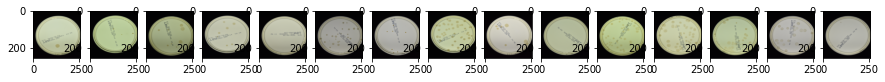

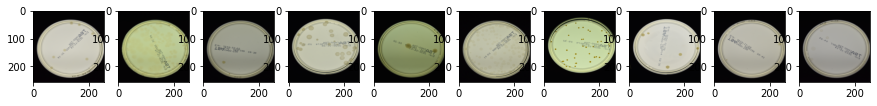

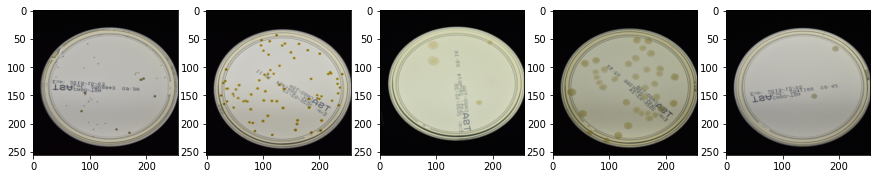

In [9]:
# Visualization order of rows: Training, Validating, Testing data
#ATTENTION: WE MUST REDUCE WHEN WE HAVE MORE DATA
plt.figure(figsize=(15,5))
for i in range(15):
    plt.subplot(1,15, i+1)
    img = X_train[i]
    plt.imshow(img)
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(1,10, i+1)
    img = X_val[i]
    plt.imshow(img)
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(1,5, i+1)
    img = X_test[i]
    plt.imshow(img)

## (3) Data Augmentation (TESTING)

❓ Question: Should we create a cycle that keeps using the augmented data to create even more augmented data, or simply augment from the same X_train every time?
❓

First we create our image generating model and train it on our X_train.

Then we create our augmented data.

Plotting our data next to our augmented data.
`Comments below are simply tests to actually expand the data. As of now, expanded data is not in use`

## (4) Using a pre-trained CNN = Transfer learning

### (4.1) Load VGG16 model

Have a look at the documentation 📚  [tf/keras/applications/VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16)📚


First we create a function to load the model:

In [10]:
def load_model():
    
    model=VGG16(
    include_top=False,
    weights='imagenet',#None
    input_tensor=None,
    input_shape=(256,256,3),
    pooling=None,#avg or max
    classifier_activation='softmax'
    )
    
    return model

Then we create a second function to lock the trainability of the layers we want to remain untouched:

In [11]:
def set_nontrainable_layers(model):
    model.trainable=True
    return model

At last we sequentialize all the previous steps with our custom layers (highlighted with comments):

In [12]:
def final_architecture():
    base_model = load_model()
    base_model = set_nontrainable_layers(base_model)

    #############
    flattening_layer = layers.Flatten()
    dense_layer1 = layers.Dense(50, activation='relu')
    batch = BatchNormalization()
    dense_layer2 = layers.Dense(50, activation='relu')
    prediction_layer = layers.Dense(num_classes, activation='softmax')#don't edit this one, only layers above it
    #############

    model = Sequential([
      base_model,
      flattening_layer,
      dense_layer1,
      batch,
      dense_layer2,
      prediction_layer
    ])
    return model

Visualize the parameters of our final architecture:

In [13]:
model=final_architecture()
model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 50)                1638450   
                                                                 
 batch_normalization (BatchN  (None, 50)               200       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 5)                 25

We finalize our module with a custom made compilation function.
❓ Question: Could Adam be the best optimizer?
❓

In [14]:
def custom_f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
from sklearn.metrics import recall_score

def build_model():
    model_compiled=final_architecture()

    opt=Adam(
    learning_rate=1e-4
    )

    model_compiled.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy',custom_f1])
    return model_compiled

### (5.2) VGG Preprocessing (preparation to use fit our data)

In [16]:
X_train_end = preprocess_input(X_train)
X_val_end = preprocess_input(X_val)
X_test_end = preprocess_input(X_test)

### (5.3)  EUREKA, we can fit the model

In [17]:
model_final=build_model()

es = EarlyStopping(
    patience=10,
    monitor='val_accuracy', # We really want to detect the accuracy of the validation data
    restore_best_weights=True)

history=model_final.fit(X_train_end, y_train,
          epochs=100,  # Use early stopping in practice
          validation_data=(X_val_end, y_val),
          batch_size=16, 
          verbose=1,
         callbacks=[es])

Epoch 1/100
40/40 [==============================] - 15s 94ms/step - loss: 1.2530 - accuracy: 0.4779 - custom_f1: 0.3296 - val_loss: 21.6006 - val_accuracy: 0.2050 - val_custom_f1: 0.2067
Epoch 2/100
40/40 [==============================] - 2s 56ms/step - loss: 0.9425 - accuracy: 0.6924 - custom_f1: 0.5301 - val_loss: 2.5921 - val_accuracy: 0.3300 - val_custom_f1: 0.3290
Epoch 3/100
40/40 [==============================] - 2s 56ms/step - loss: 0.7613 - accuracy: 0.7744 - custom_f1: 0.6706 - val_loss: 3.2129 - val_accuracy: 0.4000 - val_custom_f1: 0.4038
Epoch 4/100
40/40 [==============================] - 2s 56ms/step - loss: 0.6863 - accuracy: 0.7934 - custom_f1: 0.7327 - val_loss: 1.3216 - val_accuracy: 0.4300 - val_custom_f1: 0.4145
Epoch 5/100
40/40 [==============================] - 2s 55ms/step - loss: 0.5370 - accuracy: 0.8533 - custom_f1: 0.8123 - val_loss: 0.6710 - val_accuracy: 0.7550 - val_custom_f1: 0.7641
Epoch 6/100
40/40 [==============================] - 2s 55ms/step - 

Plot the accuracy for both the train set and and the validation set using the usual function below:

In [18]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2 ,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(25, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()
    ax1.grid()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    ax2.grid()

    ax3.plot(history.history['custom_f1'], label='F1'  + exp_name)
    ax3.plot(history.history['val_custom_f1'], label='F1'  + exp_name)
    #ax3.set_ylim(0.25, 1.)
    ax3.set_title('F1')
    ax3.legend()
    ax3.grid()
    
    return (ax1, ax2, ax3)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5b211b87d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5a844bb890>)

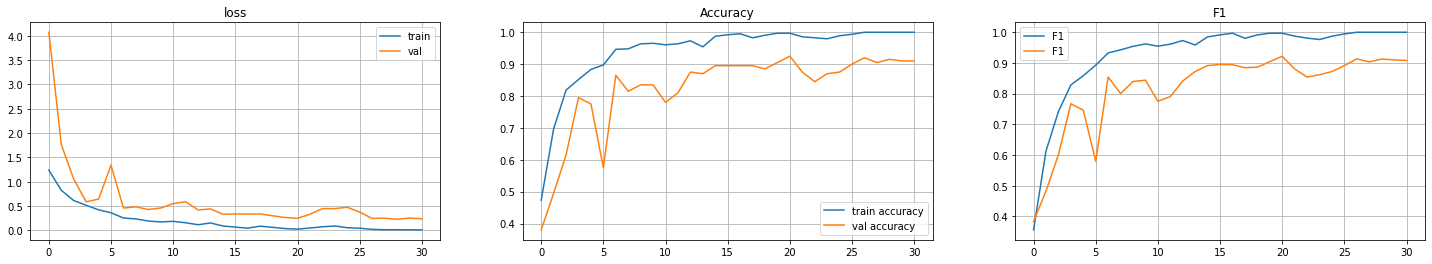

In [ ]:
plot_history(history)

Plot the confusion matrix to check which species are performing better:

In [19]:
y_pred=model_final.predict(X_test_end)
y_pred_end=y_pred.round(decimals=0,out=None)
y_pred_end=np.argmax(y_pred_end, axis=1)
y_test_end=np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_end, y_pred_end)

6/6 [==============================] - 1s 68ms/step


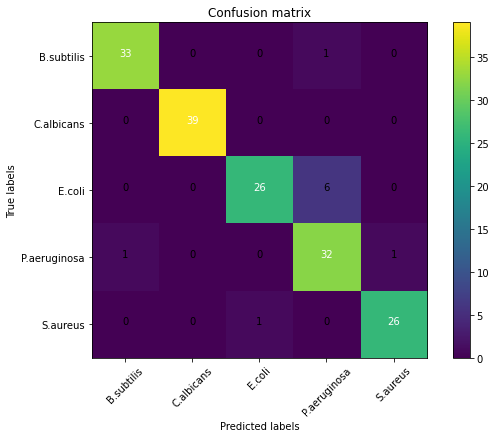

In [20]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    if cmap is None:
        cmap = plt.get_cmap('viridis')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
     
# a tuple for all the class names
plot_confusion_matrix(cm, classes_input)

Question: Evaluating the model


In [21]:
print(model_final.evaluate(X_test_end, y_test, verbose=1))
#history.__dict__

6/6 [==============================] - 0s 31ms/step - loss: 0.2051 - accuracy: 0.9398 - custom_f1: 0.9449
[0.20511433482170105, 0.9397590160369873, 0.9448577761650085]


Plot the comparision for accuracy and loss between 2 history's of choice, using the fucntion below:

In [22]:
def plot_compare_history(history, name_history, history_1, name_history_1):
    
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    ax[0].set_title('loss')
    
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss " + name_history)
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss " + name_history)
    
    ax[0].plot(history_1.epoch, history_1.history["loss"], label="Train loss " + name_history_1)
    ax[0].plot(history_1.epoch, history_1.history["val_loss"], label="Validation loss " + name_history_1)
    
    ax[1].set_title('Accuracy')
    
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy " + name_history)
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy " + name_history)
    
    ax[1].plot(history_1.epoch, history_1.history["accuracy"], label="Train Accuracy " + name_history_1)
    ax[1].plot(history_1.epoch, history_1.history["val_accuracy"], label="Validation Accuracy " + name_history_1)

    ax[2].set_title('Recall')
    
    ax[2].plot(history.epoch, history.history["custom_f1"], label="Train F1 " + name_history)
    ax[2].plot(history.epoch, history.history["val_custom_f1"], label="Validation F1 " + name_history)
    
    ax[2].plot(history_1.epoch, history_1.history["custom_f1"], label="Train F1 " + name_history_1)
    ax[2].plot(history_1.epoch, history_1.history["val_custom_f1"], label="Validation F1 " + name_history_1)
    
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

In [ ]:
#ADD here history_1 if you want to compare two historys of different models
plot_compare_history(history, "Basic CNN", history_1, "Data Augmentation")

NameError: ignored

In [ ]:
print(model_final_aug.evaluate(X_test_end, y_test, verbose=1))
history_1.__dict__

NameError: ignored

## (6) (Optional) Improve the model